# Regression task

In this notebook, we will:
- #### Simulate daily streamflow ($Q$) in a mountain using precipitation, snow, and temperature data
- First, necessary modules are imported.
- Then, the data is loaded and inspected.
- After that, ML starts...
- Making the pipeline.
- Using GridSearch.
- Checking results.

#### Make sure to:
- Get a notion of *how your ML model works*.
- *Select hyperparameters* to optimize.
- Execute *GridSearch*.
- Check model, particularly *test results*.
- Is the methodology *valid*?

#### About the models:
- Linear (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- Polynomial (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
- Multilayer Perceptron (ANN) (https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)
- Random Forests (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- Support-vector regression (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

## Load data

Let's load and look at the data using the *pandas* module (`pd.read_csv()`).
Also, we separate the test data to use at the end.


In [2]:
# This is all is takes to load it!
data = pd.read_csv('regression_data.csv', index_col=0, date_format='%m/%d/%Y')

# To split the data by dates

X = data.loc[data.index<'2021-01-01', :].iloc[:, 1:]
y = data.loc[data.index<'2021-01-01', :].iloc[:, 0]
X_test = data.loc[data.index>='2021-01-01', :].iloc[:, 1:]
y_test = data.loc[data.index>='2021-01-01', :].iloc[:, 0]

# To print
data

,Q,Precipitation__1,Precipitation__2,Precipitation__3,Precipitation_lag1__1,Precipitation_lag1__2,Precipitation_lag1__3,Precipitation_lag2__1,Precipitation_lag2__2,Precipitation_lag2__3,...,Precipitation_lag3__3,Precipitation_sum5__1,Precipitation_sum5__2,Precipitation_sum5__3,Snow__1,Snow__2,Snow__3,Temperature__1,Temperature__2,Temperature__3
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-01,50.63467,14.226824,11.260536,6.121598,14.226824,11.260536,6.121598,14.226824,11.260536,6.121598,...,6.121598,71.134120,56.302679,30.607992,0.177557,0.224239,0.188797,-1.511846,-4.208994,-7.231739
2003-01-02,31.05875,18.070795,11.416133,5.998084,14.226824,11.260536,6.121598,14.226824,11.260536,6.121598,...,6.121598,80.744046,56.691671,30.299205,0.182879,0.231161,0.192691,-1.299691,-3.979320,-6.149471
2003-01-03,11.48283,11.636812,8.981846,5.065330,18.070795,11.416133,5.998084,14.226824,11.260536,6.121598,...,6.121598,73.224052,52.764191,28.641687,0.198709,0.242604,0.198728,-1.037959,-3.754680,-6.392464
2003-01-04,54.28899,9.645329,8.609452,5.483716,11.636812,8.981846,5.065330,18.070795,11.416133,5.998084,...,6.121598,66.974701,50.334959,28.335910,0.208940,0.251606,0.203828,-1.811672,-4.749707,-7.622362
2003-01-05,20.64813,4.080652,3.490326,2.647886,9.645329,8.609452,5.483716,11.636812,8.981846,5.065330,...,5.998084,57.660413,43.758293,25.316614,0.218217,0.260235,0.209343,-2.310963,-5.319207,-7.790916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,31.00000,0.003757,0.012898,0.088563,0.004276,0.014273,0.095557,0.004795,0.015649,0.102552,...,0.109546,0.023973,0.078245,0.512759,0.025713,0.093882,0.074671,-4.680730,-10.056342,-12.148339
2022-12-28,34.70362,0.003238,0.011522,0.081569,0.003757,0.012898,0.088563,0.004276,0.014273,0.095557,...,0.102552,0.021378,0.071367,0.477787,0.029569,0.095498,0.075266,-4.030425,-7.762610,-10.072059
2022-12-29,32.00000,0.002719,0.010147,0.074574,0.003238,0.011522,0.081569,0.003757,0.012898,0.088563,...,0.095557,0.018783,0.064489,0.442815,0.044051,0.104052,0.079869,-8.430137,-11.441322,-12.998128


## How does it look?

Now we use pandas (`data.plot()`) to create a few plots.  
Its works with `matplotlib`, similarly to `plt.plot()`.

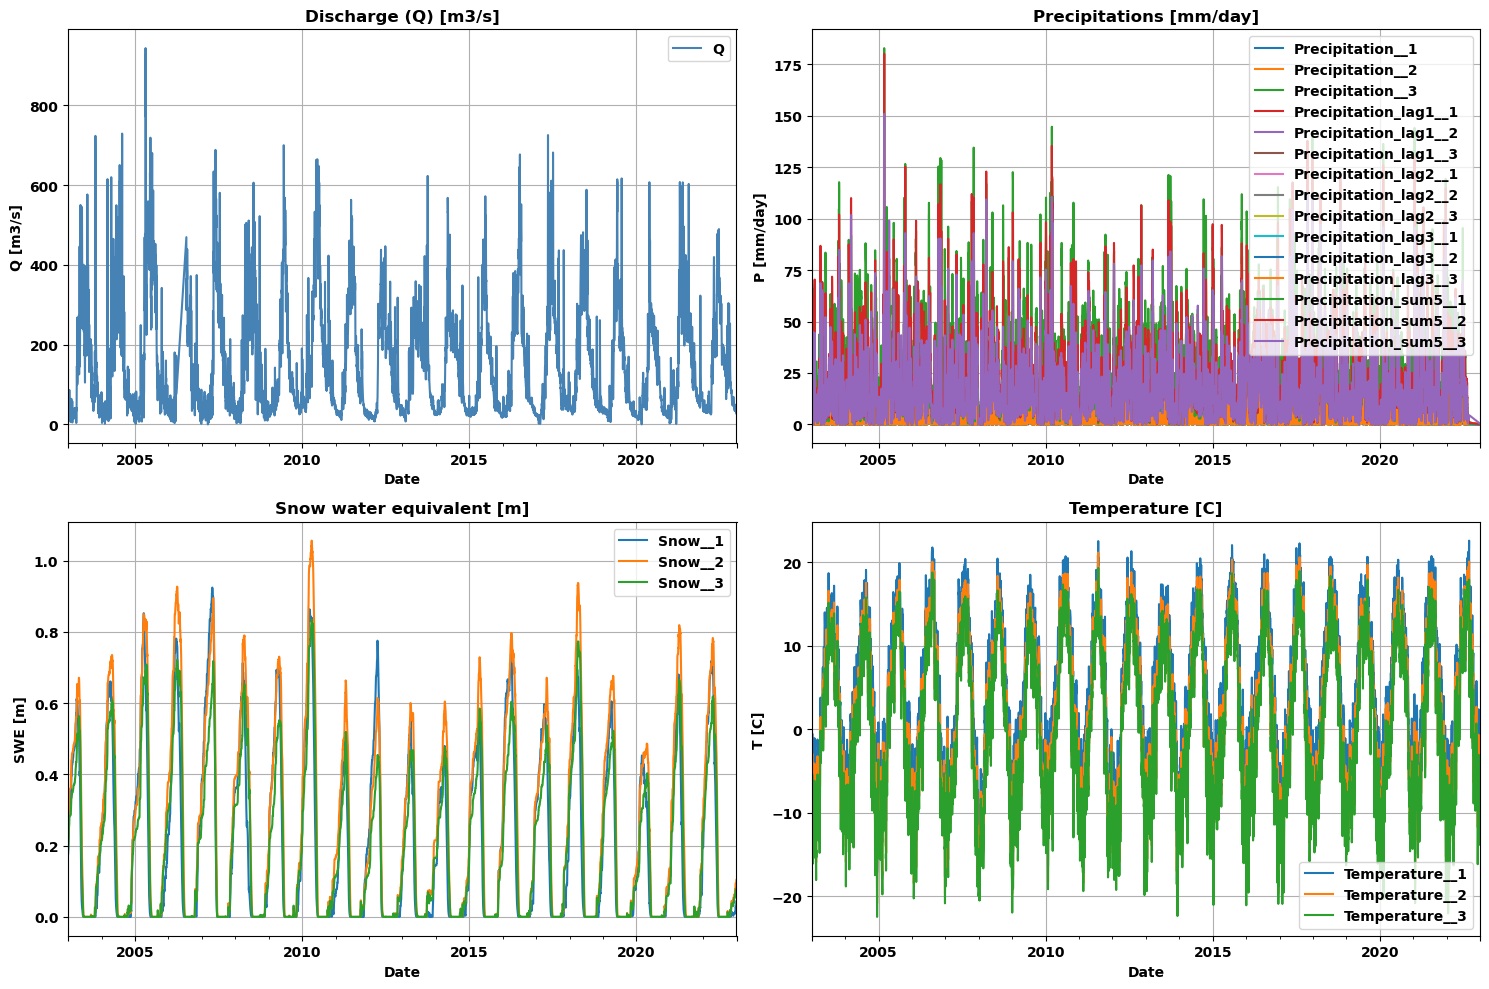

In [3]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# Plot 1: Q (Discharge)
data.loc[:, ['Q']].plot(color='steelblue', label='Q [m3/s]', ax=axs[0])
axs[0].set_title('Discharge (Q) [m3/s]')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Q [m3/s]')
axs[0].legend()
axs[0].grid(True)

# Plot 2: All Precipitations
# (Assuming the base precipitation columns; adjust if you want to include lag or sum columns)
precip_cols = ['Precipitation__1', 'Precipitation__2', 'Precipitation__3',
              'Precipitation_lag1__1', 'Precipitation_lag1__2', 'Precipitation_lag1__3',
              'Precipitation_lag2__1', 'Precipitation_lag2__2', 'Precipitation_lag2__3',
              'Precipitation_lag3__1', 'Precipitation_lag3__2', 'Precipitation_lag3__3',
              'Precipitation_sum5__1', 'Precipitation_sum5__2', 'Precipitation_sum5__3',
              ]
data.loc[:, precip_cols].plot(ax=axs[1])
axs[1].set_title('Precipitations [mm/day]')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('P [mm/day]')
axs[1].legend()
axs[1].grid(True)

# Plot 3: All Snows
snow_cols = ['Snow__1', 'Snow__2', 'Snow__3']
data.loc[:, snow_cols].plot(ax=axs[2])
axs[2].set_title('Snow water equivalent [m]')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('SWE [m]')
axs[2].legend()
axs[2].grid(True)

# Plot 4: All Temperatures
temp_cols = ['Temperature__1', 'Temperature__2', 'Temperature__3']
data.loc[:, temp_cols].plot(ax=axs[3])
axs[3].set_title('Temperature [C]')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('T [C]')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()

## Hyperparameter tuning with grid search

Now we perform a grid search with k-fold cross-validation to tune hyperparameters.  
Make sure you choose the correct ones. Check the docs and think about the model.  
Use only a few combinations to keep the grid search fast.  


In [ ]:
# Create a pipeline (using placeholders for hyperparameters to be tuned)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('regressor', MLPRegressor()),  
])

# Define the parameter grid for tuning
param_grid = {
    'pca__n_components': [2, 4, 10], # Try different dimensionalities
    'regressor__hidden_layer_sizes': [10, 20, 50],
    'regressor__alpha': [1, 0.01, 0.0001],
}

# Set up k-fold cross-validation
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Create and run the GridSearchCV (MAE scoring is used)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_absolute_error', verbose=2)
grid_search.fit(X, y)

# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=1, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=1, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=1, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=1, regressor__hidden_layer_sizes=20; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=1, regressor__hidden_layer_sizes=20; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=1, regressor__hidden_layer_sizes=20; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=1, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=1, regressor__hidden_layer_sizes=50; total time=   0.4s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=1, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.01, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.01, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.01, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.01, regressor__hidden_layer_sizes=20; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.01, regressor__hidden_layer_sizes=20; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.01, regressor__hidden_layer_sizes=20; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.01, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.01, regressor__hidden_layer_sizes=50; total time=   0.4s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.01, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.0001, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.0001, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.0001, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.0001, regressor__hidden_layer_sizes=20; total time=   0.4s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.0001, regressor__hidden_layer_sizes=20; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.0001, regressor__hidden_layer_sizes=20; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.0001, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.0001, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=2, regressor__alpha=0.0001, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=1, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=1, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=1, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=1, regressor__hidden_layer_sizes=20; total time=   0.4s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=1, regressor__hidden_layer_sizes=20; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=1, regressor__hidden_layer_sizes=20; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=1, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=1, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=1, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.01, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.01, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.01, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.01, regressor__hidden_layer_sizes=20; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.01, regressor__hidden_layer_sizes=20; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.01, regressor__hidden_layer_sizes=20; total time=   0.4s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.01, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.01, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.01, regressor__hidden_layer_sizes=50; total time=   0.5s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.0001, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.0001, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.0001, regressor__hidden_layer_sizes=10; total time=   0.3s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.0001, regressor__hidden_layer_sizes=20; total time=   0.4s


c:\Users\zepedro\.conda\envs\pmnec\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END pca__n_components=4, regressor__alpha=0.0001, regressor__hidden_layer_sizes=20; total time=   0.4s


## Evaluate test data

Let's see how it works!

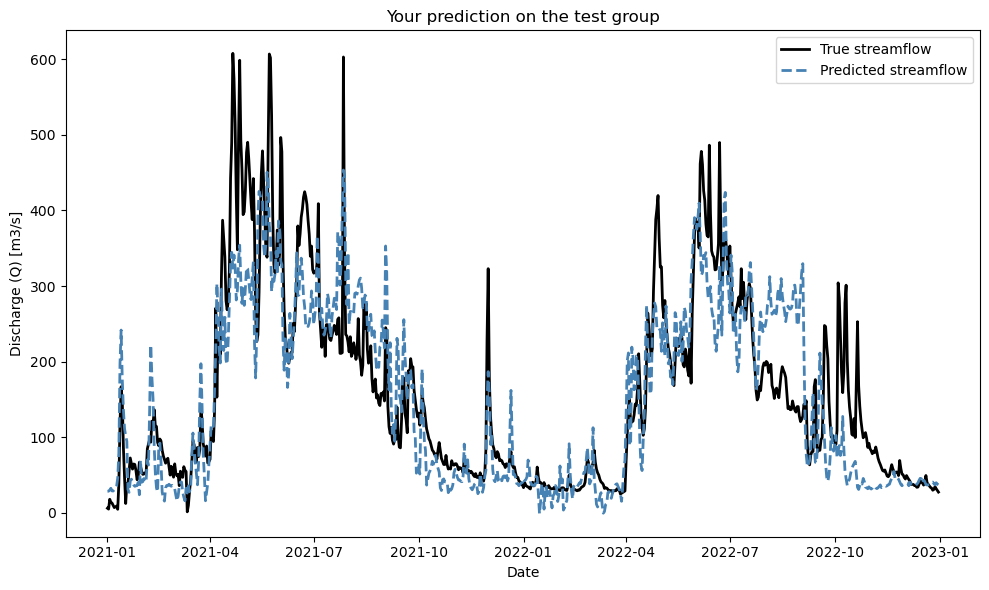

RMSE: 69.96947678320083 [m3/s]


In [ ]:
# Get the retrained best estimator
trained_model = grid_search.best_estimator_

# Or, if you wish to train it with custom parameters...
#trained_model = pipeline.set_params(pca__n_components=10).fit(X,y)

y_pred = trained_model.predict(X_test)

# Plot the true signal, training data, and multiple predicted signals.
plt.figure(figsize=(10, 6))
# Plot the true signal line (extrapolated)
plt.plot(y_test.index, y_test.values, label="True streamflow", color="black", linewidth=2)
plt.plot(y_test.index, y_pred, label="Predicted streamflow", color="steelblue", linestyle='--', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Discharge (Q) [m3/s]')
plt.title('Your prediction on the test group')
plt.legend()
plt.tight_layout()
plt.show()

mse = mean_squared_error(y_test.values, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse, '[m3/s]')